In [5]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format='retina'

cmap = plt.get_cmap('viridis')
norm = colors.Normalize(vmin=0, vmax=1)
subfield_colors = {
    'CA1':cmap(norm(0)),
    'Subiculum':cmap(norm(.25)),
    'CA4/DG':cmap(norm(.5)),
    'CA3/CA2':cmap(norm(.75)),
    'SRLM':cmap(norm(1)),
}

pos_colors = {
    'anterior':(63/255, 21/255, 82/255),
    'body':(119/255, 196/255, 98/255),
    'posterior':(60/255, 125/255, 140/255)
}

project_dir = '/Users/jkember/Documents/projects/hcpd'
df = pd.read_csv(f'{project_dir}/data/raw/supplementary_data.csv')
df

ID   Age  Sex    IQ  Memory  CA1_volume  Subiculum_volume  \
0    'HCD0001305'  11.9  0.0  11.0   124.0    846.8420          391.1650   
1    'HCD0036324'  16.8  1.0   NaN     NaN    625.1510          248.3200   
2    'HCD0039128'  15.3  0.0   NaN     NaN    668.6750          268.8010   
3    'HCD0040113'   9.3  0.0  11.0     NaN    624.8945          355.3270   
4    'HCD0041822'  17.4  0.0   NaN   121.0    904.7090          353.2820   
..            ...   ...  ...   ...     ...         ...               ...   
359  'HCD2976382'  11.3  0.0   9.0    94.0    885.7570          439.2940   
360  'HCD2978386'   9.2  0.0   NaN     NaN    808.9580          269.8230   
361  'HCD2982579'  18.8  1.0  11.0   123.0    765.9510          306.4320   
362  'HCD2985181'  10.9  0.0   NaN     NaN    843.2700          402.4345   
363  'HCD2996590'  19.8  0.0  14.0   123.0    843.0050          422.9110   

     CA4/DG_volume  CA3/CA2_volume  CA3/CA2_volume.1  ...  AD_anterior  \
0          555.004       163.83900           598.012  ...     0.000889   
1          474.623       150.52800           423.423  ...     0.000870   
2          534.531       164.86500           453.122  ...     0.000889   
3          461.567       104.19190           454.143  ...     0.000885   
4          611.843       151.04100           626.179  ...     0.000840   
..             ...             ...               ...  ...          ...   
359        760.829       158.20700           652.798  ...     0.000935   
360        550.399       145.40800           498.687  ...     0.000973   
361        572.416       137.21600           527.872  ...     0.000854   
362        655.876       156.92900           603.652  ...     0.000930   
363        635.390       115.71185           583.422  ...     0.000887   

     RD_posterior   RD_body  RD_anterior  ODI_posterior  ODI_body  \
0        0.000667  0.000710     0.000709       0.307250  0.352838   
1        0.000683  0.000628     0.000697       0.303042  0.454970   
2        0.000653  0.000708     0.000729       0.326200  0.384724   
3        0.000680  0.000710     0.000704       0.301397  0.331931   
4        0.000640  0.000663     0.000676       0.275076  0.357539   
..            ...       ...          ...            ...       ...   
359      0.000674  0.000722     0.000723       0.266552  0.345707   
360      0.000599  0.000632     0.000669       0.240455  0.267396   
361      0.000613  0.000641     0.000653       0.283714  0.344018   
362      0.000678  0.000725     0.000720       0.312925  0.368009   
363      0.000653  0.000712     0.000691       0.290980  0.385928   

     ODI_anterior  NDI_posterior  NDI_body  NDI_anterior  
0        0.379021       0.266403  0.243837      0.251735  
1        0.381380       0.264043  0.297233      0.269766  
2        0.405809       0.279361  0.267597      0.270893  
3        0.361027       0.220002  0.211626      0.223048  
4        0.412900       0.248896  0.244123      0.262722  
..            ...            ...       ...           ...  
359      0.330234       0.264975  0.234482      0.234627  
360      0.277824       0.266378  0.256285      0.283972  
361      0.362094       0.292505  0.270715      0.302644  
362      0.346241       0.236306  0.222403      0.261065  
363      0.360029       0.342603  0.308139      0.259354  

[364 rows x 55 columns]

In [22]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold

optimal_gamma = {}


def get_optimal_gamma(feature):

    '''Find the gamma value that minimizes the average test MSE.'''

    x = df['Age'].to_numpy().reshape(-1, 1)
    y = df[feature].to_numpy().reshape(-1, 1)

    gamma_vals = np.linspace(0, .1, 500)
    kf = KFold(n_splits=5, shuffle=True)

    split = 0
    mse = np.zeros([5, 500])
    for train_index, test_index in kf.split(x):

        x_train, x_test = [x[i] for i in train_index], [x[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        for gamma_idx, gamma in enumerate(gamma_vals):

            kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)
            kr.fit(x_train, y_train)
            mse[split,gamma_idx] = np.sum((kr.predict(x_test) - y_test)**2)

        split += 1

    optimal_gamma = gamma_vals[np.argmin(mse.mean(axis=0))]
    return optimal_gamma


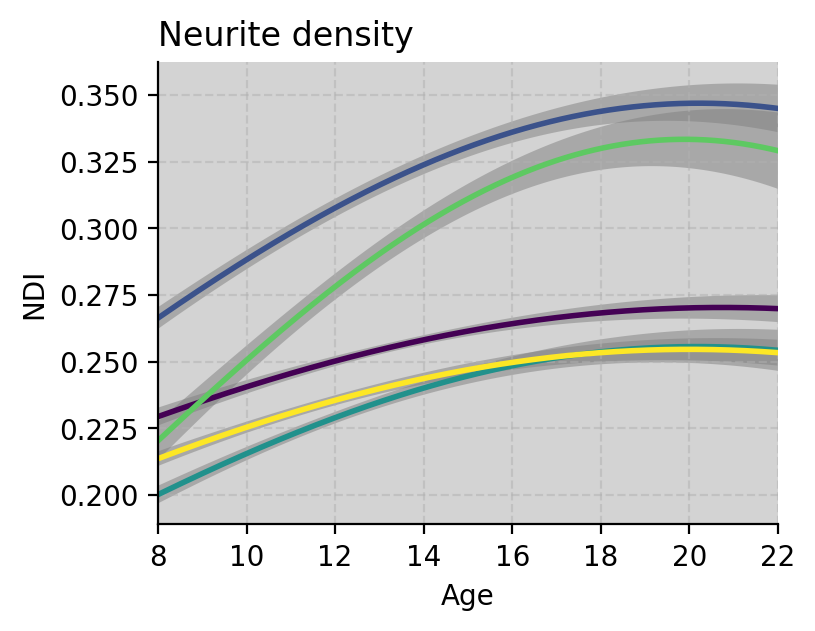

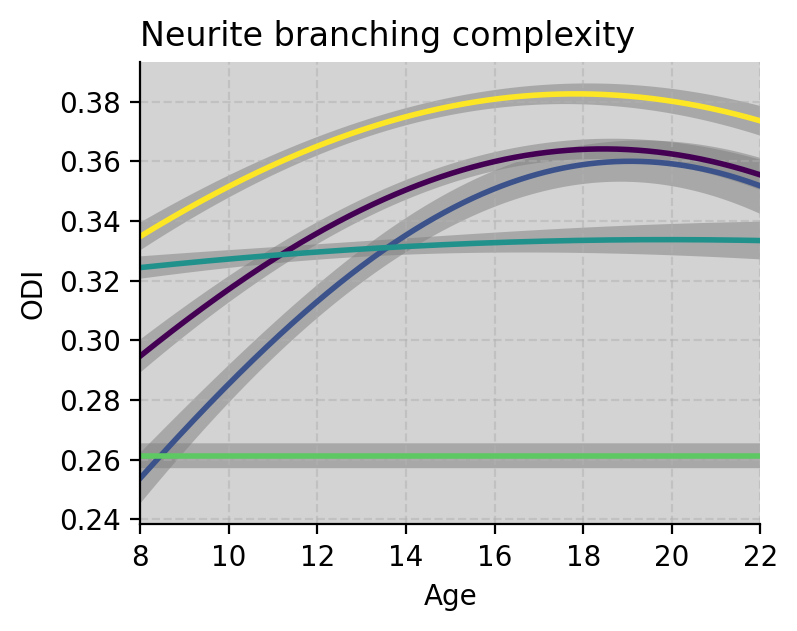

In [ ]:
from sklearn.kernel_ridge import KernelRidge

n_perm = 50
n_subject = df.shape[0]
x_new = np.linspace(8, 22, 1000).reshape(-1, 1)

gamma_vals = {}
y_pred = {}

for feature in ['NDI','ODI']:
    for subfield in subfield_colors.keys():

        gamma = get_optimal_gamma(f'{feature}-{subfield}')
        kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)
        gamma_vals[f'{subfield}_{feature}'] = gamma

        y_pred[f'{subfield}_{feature}'] = []
        for n in range(n_perm):
            df_sample = df.sample(n_subject, replace=True)
            x = df_sample['Age'].to_numpy().reshape(-1, 1)
            y = df_sample[f'{feature}-{subfield}'].to_numpy().reshape(-1, 1)
            kr.fit(x, y)
            y_pred[f'{subfield}_{feature}'].append(kr.predict(x_new))


titles = ['Neurite density', 'Neurite branching complexity']
age = np.concatenate(x_new)

for idx, feature in enumerate(['NDI','ODI']):
    fig, ax = plt.subplots(1, figsize=(4, 3))
    for subfield in subfield_colors.keys():

        y_mean = np.concatenate(np.mean(y_pred[f'{subfield}_{feature}'], axis=0))
        y_se = np.concatenate(np.std(y_pred[f'{subfield}_{feature}'], axis=0)*1.96)

        ax.plot(age, y_mean, color=subfield_colors[subfield], lw=2)
        ax.fill_between(age, y_mean+y_se, y_mean-y_se, alpha=.5, facecolor='tab:gray')
        ax.set_xlabel('Age')
        ax.set_ylabel(feature)
        ax.set_xlim([8, 22])
        ax.set_title(titles[idx], loc='left')
        ax.set_facecolor('lightgray')

        ax.grid(linestyle='--', alpha=.5)
        sns.despine()

    plt.show()


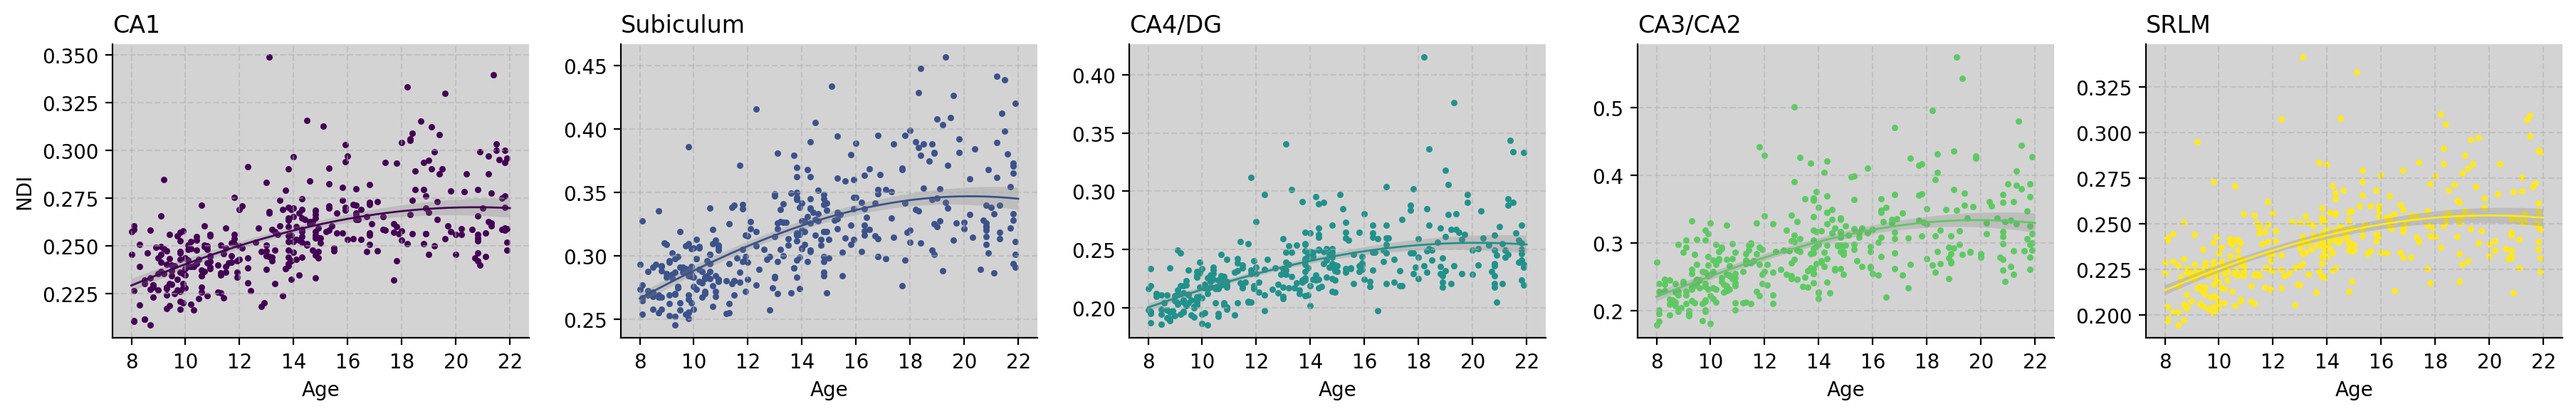

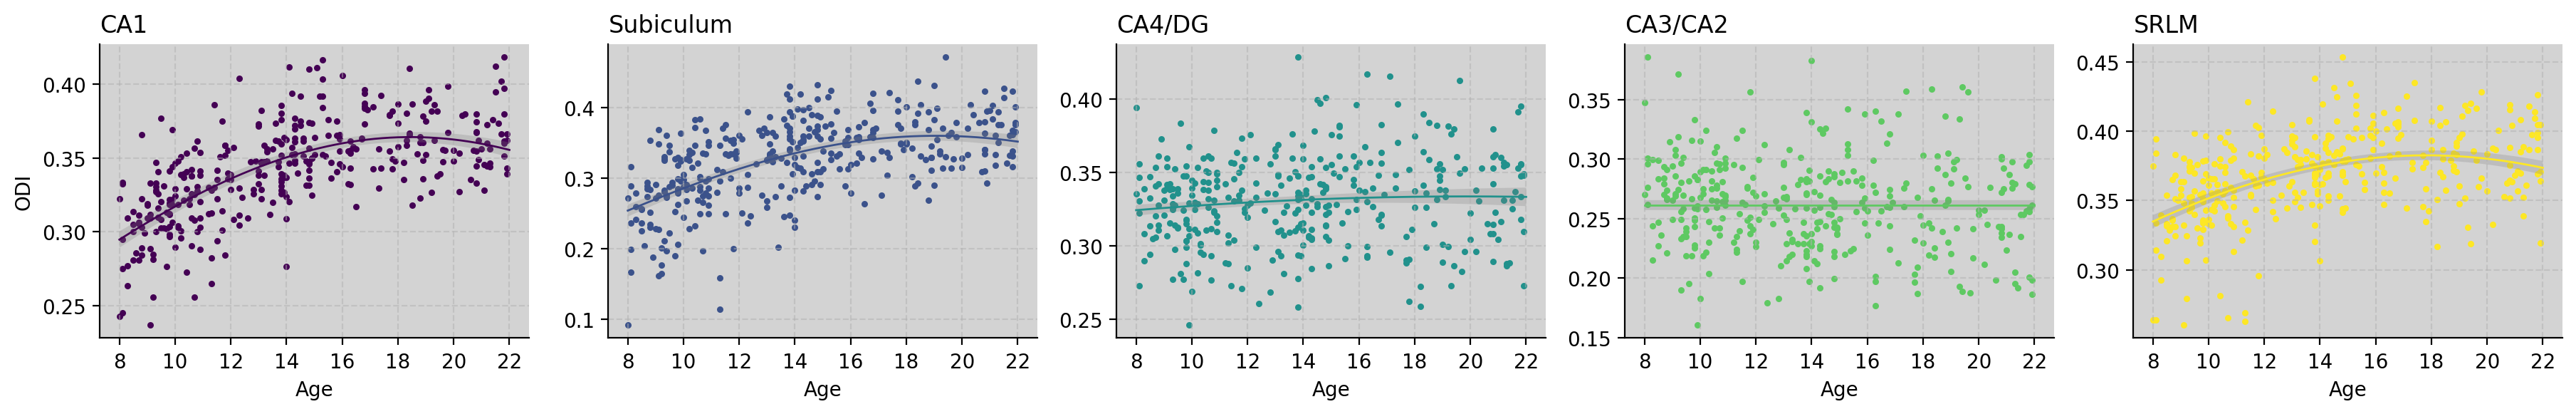

In [58]:
ylims = {'NDI':(.15,.6),'ODI':(.1,.5),'MD':(.58, 1.09)}

for feature in ['NDI','ODI']:

    fig, ax = plt.subplots(1, 5, figsize=(18, 3))

    for idx, subfield in enumerate(subfield_colors.keys()):

        fit_mean = np.concatenate(np.mean(y_pred[f'{subfield}_{feature}'], axis=0))
        fit_se = np.concatenate(np.std(y_pred[f'{subfield}_{feature}'], axis=0)*1.96)

        ax[idx].scatter(df['Age'], df[f'{feature}-{subfield}'], s=5, color=subfield_colors[subfield])
        ax[idx].plot(age, fit_mean, lw=1, color=subfield_colors[subfield])
        ax[idx].fill_between(age, fit_mean+fit_se, fit_mean-fit_se, lw=2, facecolor='tab:gray', alpha=.25)
        ax[idx].grid(linestyle='--', alpha=.5)
        ax[idx].set_facecolor('lightgray')
        ax[idx].set_xticks([8,10,12,14,16,18,20,22])
        ax[idx].set_xlabel('Age')

        # ax[idx].set_ylim(ylims[feature])
        ax[idx].set_title(subfield, loc='left')
        sns.despine()
        plt.tight_layout()

    ax[0].set_ylabel(feature)
    plt.show()

In [11]:
for subfield in subfield_colors.keys():
    display(subfield)
    display(pg.corr(df['Age'], df[f'ODI-{subfield}']))


'CA1'

n         r         CI95%         p-val       BF10  power
pearson  364  0.619111  [0.55, 0.68]  6.796339e-40  4.034e+36    1.0

'Subiculum'

n         r         CI95%         p-val       BF10  power
pearson  364  0.546276  [0.47, 0.61]  1.052885e-29  3.347e+26    1.0

'CA4/DG'

n         r         CI95%     p-val   BF10     power
pearson  364  0.114192  [0.01, 0.21]  0.029385  0.697  0.587784

'CA3/CA2'

n         r        CI95%     p-val   BF10     power
pearson  364 -0.098849  [-0.2, 0.0]  0.059558  0.384  0.470777

'SRLM'

n         r         CI95%         p-val       BF10  power
pearson  364  0.426306  [0.34, 0.51]  1.663452e-17  3.144e+14    1.0

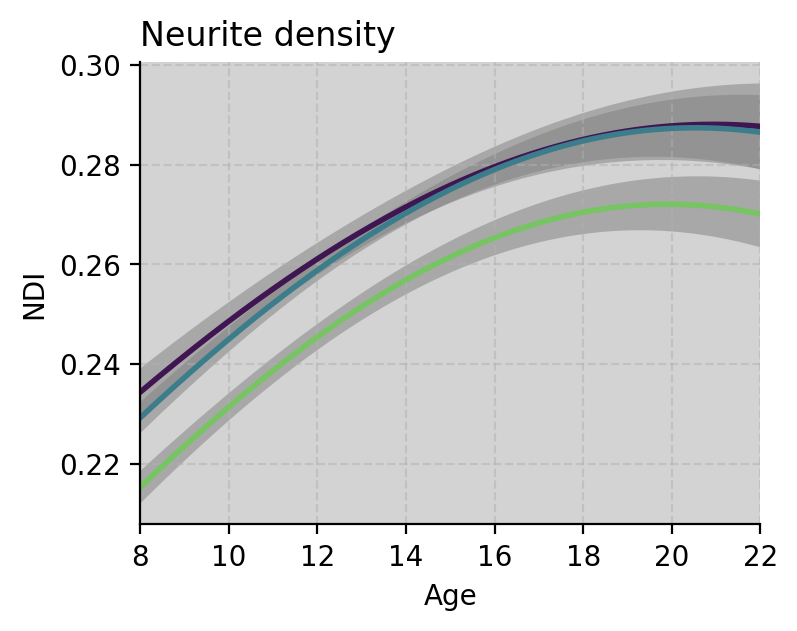

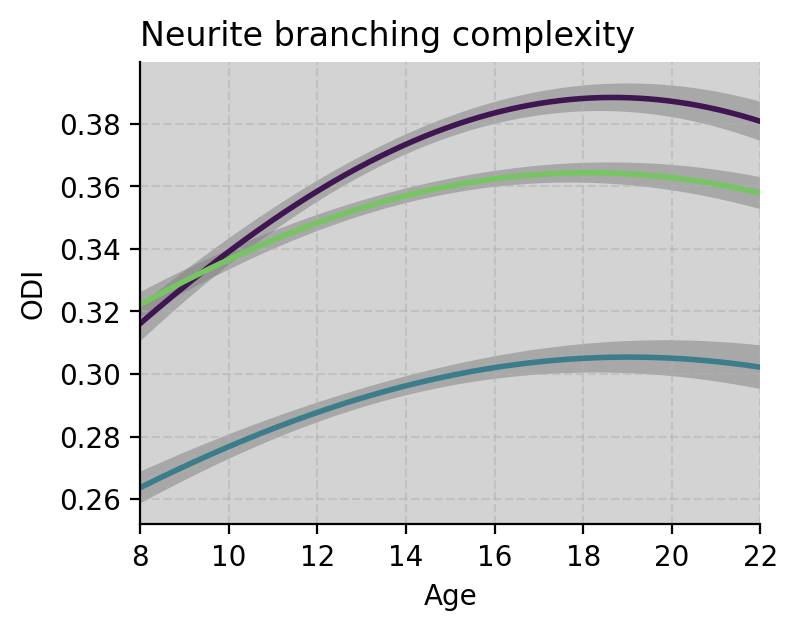

In [12]:

n_perm = 50
n_subject = df.shape[0]
x_new = np.linspace(8, 22, 1000).reshape(-1, 1)

y_pred = {}

for feature in ['NDI','ODI']:
    for pos in pos_colors.keys():

        gamma = get_optimal_gamma(f'{feature}_{pos}')
        kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)

        y_pred[f'{pos}_{feature}'] = []
        for n in range(n_perm):
            df_sample = df.sample(n_subject, replace=True)
            x = df_sample['Age'].to_numpy().reshape(-1, 1)
            y = df_sample[f'{feature}_{pos}'].to_numpy().reshape(-1, 1)
            kr.fit(x, y)
            y_pred[f'{pos}_{feature}'].append(kr.predict(x_new))


titles = ['Neurite density', 'Neurite branching complexity']
age = np.concatenate(x_new)

for idx, feature in enumerate(['NDI','ODI']):
    fig, ax = plt.subplots(1, figsize=(4, 3))

    for pos in pos_colors.keys():

        y_mean = np.concatenate(np.mean(y_pred[f'{pos}_{feature}'], axis=0))
        y_se = np.concatenate(np.std(y_pred[f'{pos}_{feature}'], axis=0)*1.96)

        ax.plot(age, y_mean, color=pos_colors[pos], lw=2)
        ax.fill_between(age, y_mean+y_se, y_mean-y_se, alpha=.5, facecolor='tab:gray')
        ax.set_xlabel('Age')
        ax.set_ylabel(feature)
        ax.set_xlim([8, 22])
        ax.set_facecolor('lightgray')
        ax.set_title(titles[idx], loc='left')
        ax.grid(linestyle='--', alpha=.5)
        sns.despine()

    plt.show()


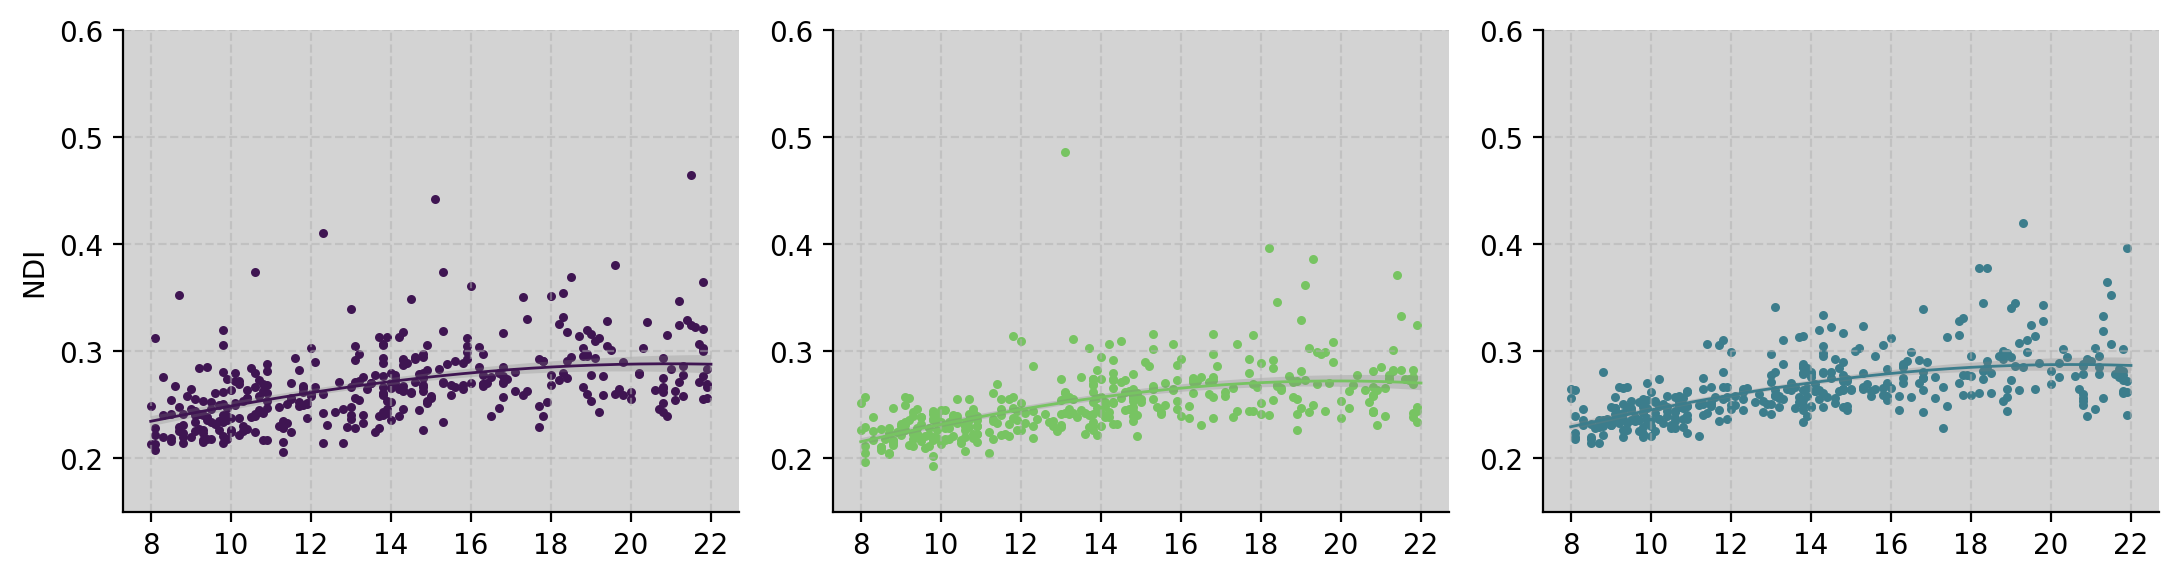

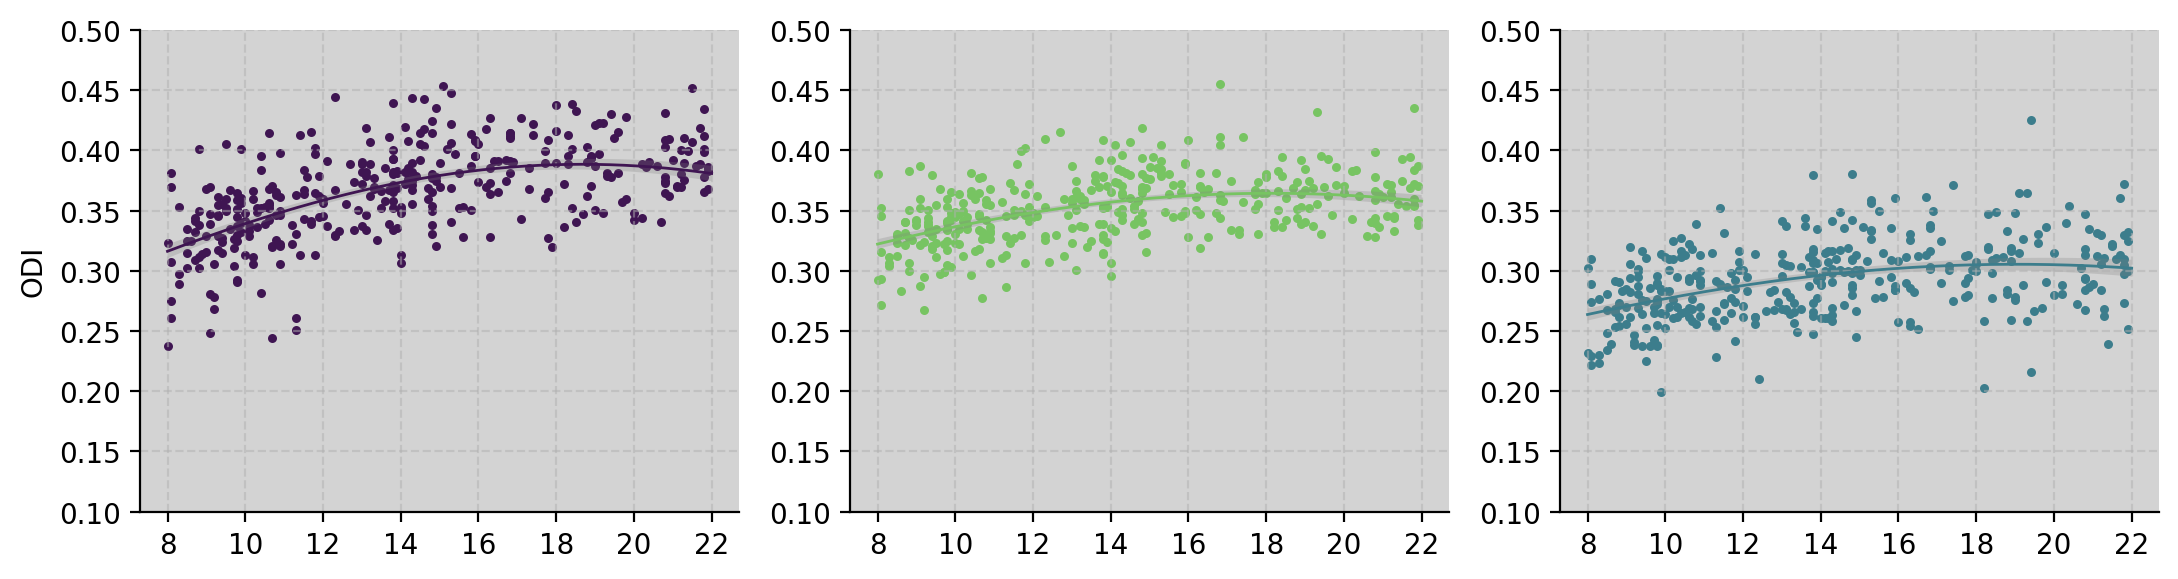

In [13]:

ylims = {'NDI':(.15,.6),'ODI':(.1,.5)}

for feature in ['NDI','ODI']:

    fig, ax = plt.subplots(1, 3, figsize=(10.8, 3))

    for idx, pos in enumerate(pos_colors.keys()):

        fit_mean = np.concatenate(np.mean(y_pred[f'{pos}_{feature}'], axis=0))
        fit_se = np.concatenate(np.std(y_pred[f'{pos}_{feature}'], axis=0)*1.96)

        ax[idx].scatter(df['Age'], df[f'{feature}_{pos}'], s=5, color=pos_colors[pos])
        ax[idx].plot(age, fit_mean, lw=1, color=pos_colors[pos])
        ax[idx].fill_between(age, fit_mean+fit_se, fit_mean-fit_se, lw=2, facecolor='tab:gray', alpha=.25)
        ax[idx].grid(linestyle='--', alpha=.5)

        ax[idx].set_xticks([8,10,12,14,16,18,20,22])
        # ax[idx].set_xlabel('Age')
        ax[idx].set_facecolor('lightgray')
        # ax[idx].set_title(pos.capitalize(), loc='left')
        ax[idx].set_ylim(ylims[feature])
        sns.despine()
        plt.tight_layout()

    ax[0].set_ylabel(feature)


In [14]:
for pos in ['anterior','body','posterior']:
    display(pos)
    display(pg.corr(df['Age'], df[f'ODI_{pos}']))


'anterior'

n         r         CI95%         p-val       BF10  power
pearson  364  0.555143  [0.48, 0.62]  8.195148e-31  4.174e+27    1.0

'body'

n         r         CI95%         p-val      BF10  power
pearson  364  0.430352  [0.34, 0.51]  7.644083e-18  6.75e+14    1.0

'posterior'

n        r         CI95%         p-val       BF10  power
pearson  364  0.38569  [0.29, 0.47]  2.339704e-14  2.561e+11    1.0

In [26]:
from scipy.stats import pearsonr

df = pd.read_csv(f'{project_dir}/data/raw/supplementary_data.csv')
df = df.sort_values('Age').reset_index(drop=True)

young = df[:121]
middle = df[121:242]
old = df[242:]


for feature in ['NDI','ODI']:
    corrs = pd.DataFrame(columns=['young','middle','old'], index=subfield_colors.keys())
    corrs_p = pd.DataFrame(columns=['young','middle','old'], index=subfield_colors.keys())

    for subfield in subfield_colors.keys():
        corrs.loc[subfield, 'young'] = pearsonr(young['Age'], young[f'{feature}-{subfield}'])[0]
        corrs.loc[subfield, 'middle'] = pearsonr(middle['Age'], middle[f'{feature}-{subfield}'])[0]
        corrs.loc[subfield, 'old'] = pearsonr(old['Age'], old[f'{feature}-{subfield}'])[0]

        corrs_p.loc[subfield, 'young'] = pearsonr(young['Age'], young[f'{feature}-{subfield}'])[1]
        corrs_p.loc[subfield, 'middle'] = pearsonr(middle['Age'], middle[f'{feature}-{subfield}'])[1]
        corrs_p.loc[subfield, 'old'] = pearsonr(old['Age'], old[f'{feature}-{subfield}'])[1]

    corrs.to_csv(f'{feature}_age_corr_groups.csv', index=False)
    display(corrs)
    display(corrs_p)


young    middle       old
CA1        0.146077  0.249654  0.060219
Subiculum  0.173333  0.252318  0.077926
CA4/DG     0.389498  0.206337  0.120498
CA3/CA2    0.360518  0.183974  0.112032
SRLM        0.20445  0.253543  0.091014

young    middle       old
CA1        0.109875  0.005753  0.509965
Subiculum  0.057264  0.005238  0.393573
CA4/DG      0.00001  0.023169  0.186147
CA3/CA2    0.000049  0.043385  0.219233
SRLM       0.024486  0.005016  0.318761

young    middle       old
CA1        0.342034  0.423133  0.070922
Subiculum  0.337206  0.285121  0.181828
CA4/DG    -0.073748  0.088671 -0.070384
CA3/CA2   -0.134899  0.042014 -0.115421
SRLM       0.172772   0.24672 -0.053958

young    middle       old
CA1        0.000123  0.000001  0.437587
Subiculum  0.000155  0.001525  0.045025
CA4/DG     0.421454  0.333463  0.441084
CA3/CA2    0.140148  0.647272  0.205519
SRLM       0.058087  0.006371  0.555002

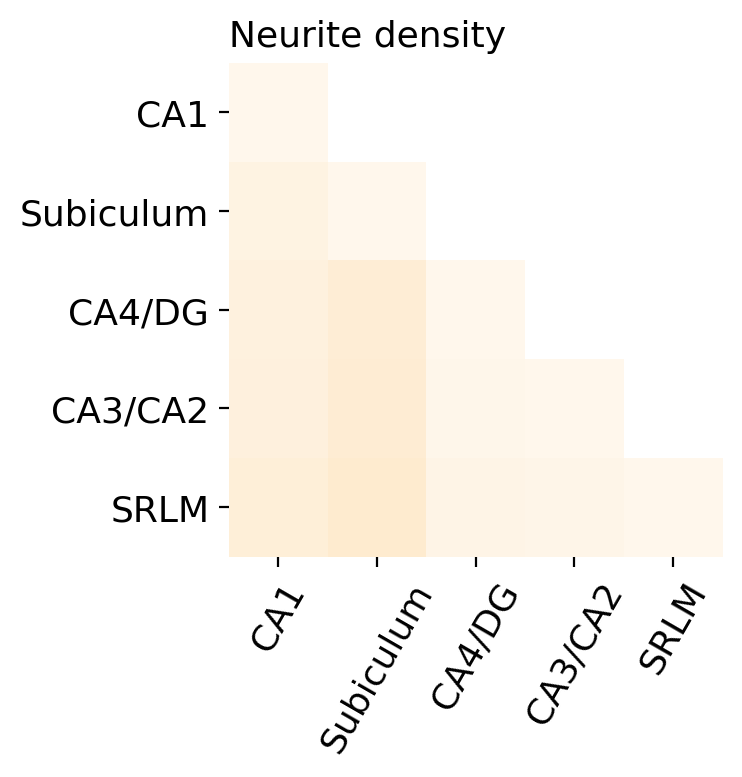

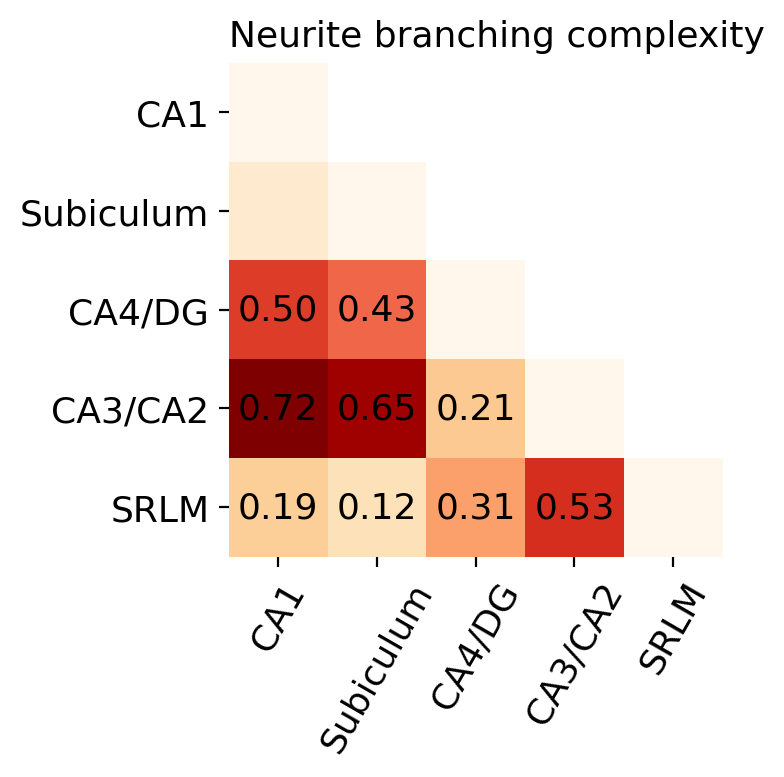

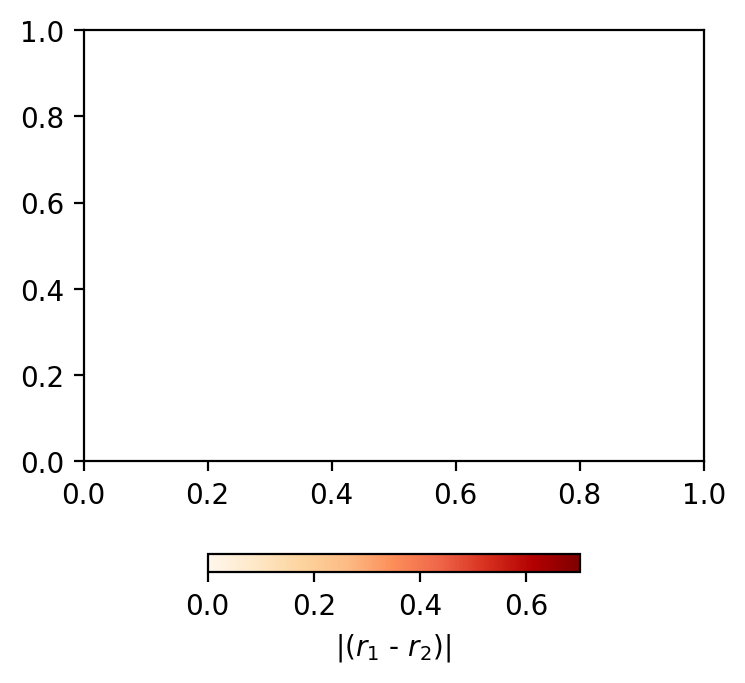

In [ ]:
from scipy.stats import norm, pearsonr, false_discovery_control

df = pd.read_csv(f'{project_dir}/data/raw/supplementary_data.csv')
df = df.sort_values('Age').reset_index(drop=True)
young = df[:121]
middle = df[121:242]
old = df[242:]


def compare_correlations(r1, r2, n):

    # Fisher's r-to-z transformation
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))

    # Standard error for the difference
    SE = 1 / np.sqrt(n - 3)

    # Z-score for the difference
    z_diff = (z1 - z2) / SE
    p_value = 2 * (1 - norm.cdf(abs(z_diff)))

    return z_diff, p_value

group = df

subfields = list(subfield_colors.keys())
titles = ['Neurite density','Neurite branching complexity','Mean diffusivity','Radial diffusivity','Axial diffusivity']

for idx, feature in enumerate(['NDI','ODI']):

    diffs = pd.DataFrame(np.zeros([5,5]), columns=subfields, index=subfields)
    p_vals = pd.DataFrame(np.zeros([5,5]), columns=subfields, index=subfields)

    for j in range(len(subfields)):
        for i in range(len(subfields)):

            diff, p = compare_correlations(
                pearsonr(group[f'{feature}-{subfields[j]}'], group['Age'])[0],
                pearsonr(group[f'{feature}-{subfields[i]}'], group['Age'])[0],
                len(group)
            )

            diffs.loc[subfields[j], subfields[i]] = np.abs(pearsonr(group[f'{feature}-{subfields[j]}'], group['Age'])[0] - pearsonr(group[f'{feature}-{subfields[i]}'], group['Age'])[0])
            p_vals.loc[subfields[j], subfields[i]] = p


    diffs.values[np.triu_indices_from(diffs, k=1)] = np.nan
    p_vals.values[np.triu_indices_from(p_vals, k=1)] = np.nan

    # FDR-correct p values.
    p_vals_flat = p_vals.values.flatten()
    p_vals_flat = p_vals_flat[~np.isnan(p_vals_flat)]
    p_vals_flat = false_discovery_control(p_vals_flat)
    adjusted_pvals = np.full(p_vals.shape, np.nan)
    adjusted_pvals[~np.isnan(p_vals)] = p_vals_flat
    p_vals[:] = adjusted_pvals


    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(diffs, cmap='OrRd', vmin=0, vmax=.7)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(subfields, fontsize=13)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(subfields, rotation=60, fontsize=13)
    ax.set_title(titles[idx], loc='left', fontsize=13)

    for j in range(len(subfields)):
        for i in range(len(subfields)):
            if p_vals.loc[subfields[j], subfields[i]] < .05:
                plt.text(i,j, f'{diffs.loc[subfields[j], subfields[i]]:.2f}', ha='center', va='center', fontsize=13)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
cbar = fig.colorbar(cax, ax=ax, label="|($r$$_1$ - $r$$_2$)|", shrink=.6, orientation='horizontal')
plt.show()


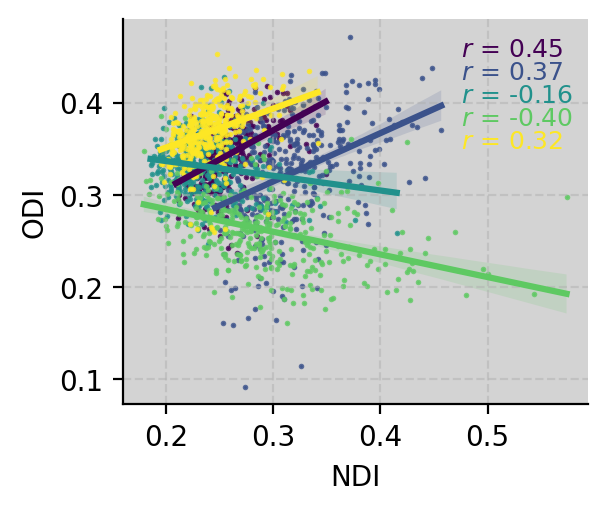

In [ ]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(3,2.5))

text_pos = [.45, .425, .4, .375, .35, .325]
for idx, subfield in enumerate(subfield_colors.keys()):
    sns.regplot(x=df[f'NDI-{subfield}'], y=df[f'ODI-{subfield}'], color=subfield_colors[subfield], scatter_kws={'s':1})
    r, p = pearsonr(df[f'NDI-{subfield}'], df[f'ODI-{subfield}'])
    ax.text(.475, text_pos[idx], f'$r$ = {r:.2f}', color=subfield_colors[subfield], fontsize=9)

ax.set_xlabel('NDI')
ax.set_ylabel('ODI')
ax.grid(linestyle='--', alpha=.5)
ax.set_facecolor('lightgray')
sns.despine()


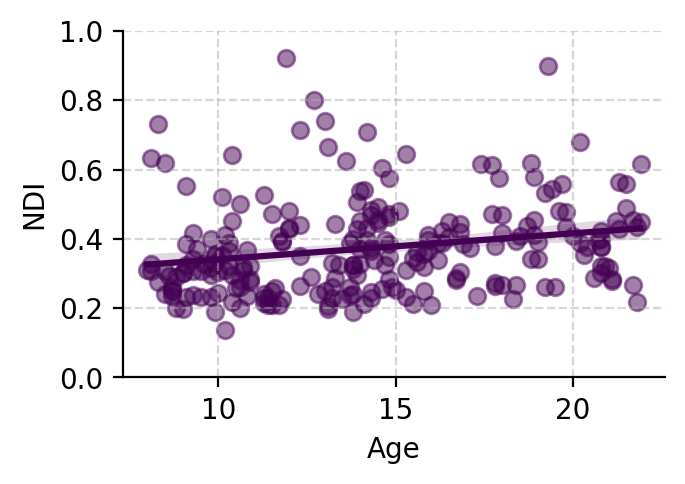

In [ ]:
for site in range(52, 53):

    ndi_vals = pd.read_excel(f'{project_dir}/miscellaneous/imaging_derived_phenotypes.xlsx', sheet_name='NDI').iloc[site,:]

    fig, ax = plt.subplots(figsize=(3.5, 2.25))
    sns.regplot(x=df['Age'][np.where(ndi_vals > 0)[0]], y=ndi_vals[np.where(ndi_vals > 0)[0]], color=subfield_colors['CA1'], scatter_kws={'alpha':0.5})
    ax.set_ylim([0,1])
    ax.grid(linestyle='--', alpha=.5)
    ax.set_ylabel('NDI')
    sns.despine()
    plt.show()


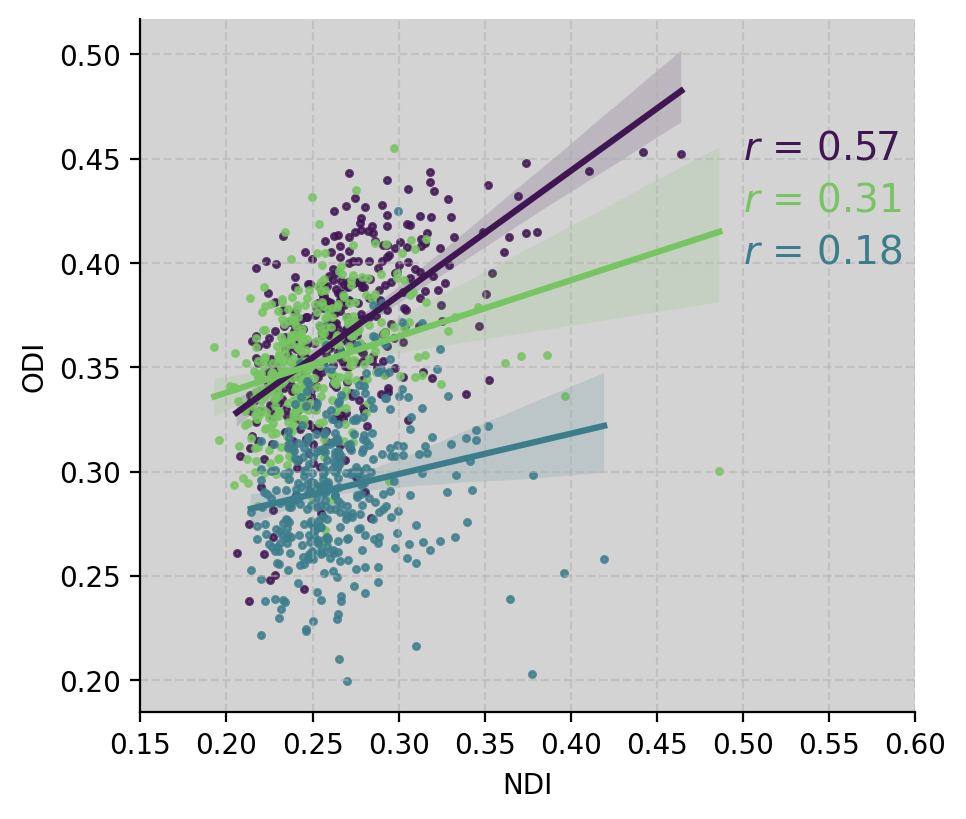

In [39]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(figsize=(5,4.5))

text_pos = [.45, .425, .4, .375, .35, .325]
for idx, subfield in enumerate(['anterior','body','posterior']):
    sns.regplot(x=df[f'NDI_{subfield}'], y=df[f'ODI_{subfield}'], color=pos_colors[subfield], scatter_kws={'s':5})
    r, p = pearsonr(df[f'NDI_{subfield}'], df[f'ODI_{subfield}'])
    ax.text(.5, text_pos[idx], f'$r$ = {r:.2f}', color=pos_colors[subfield] ,fontsize=14)

ax.set_xlabel('NDI')
ax.set_ylabel('ODI')
ax.set_xlim([.15, .6])
ax.grid(linestyle='--', alpha=.5)
ax.set_facecolor('lightgray')
sns.despine()


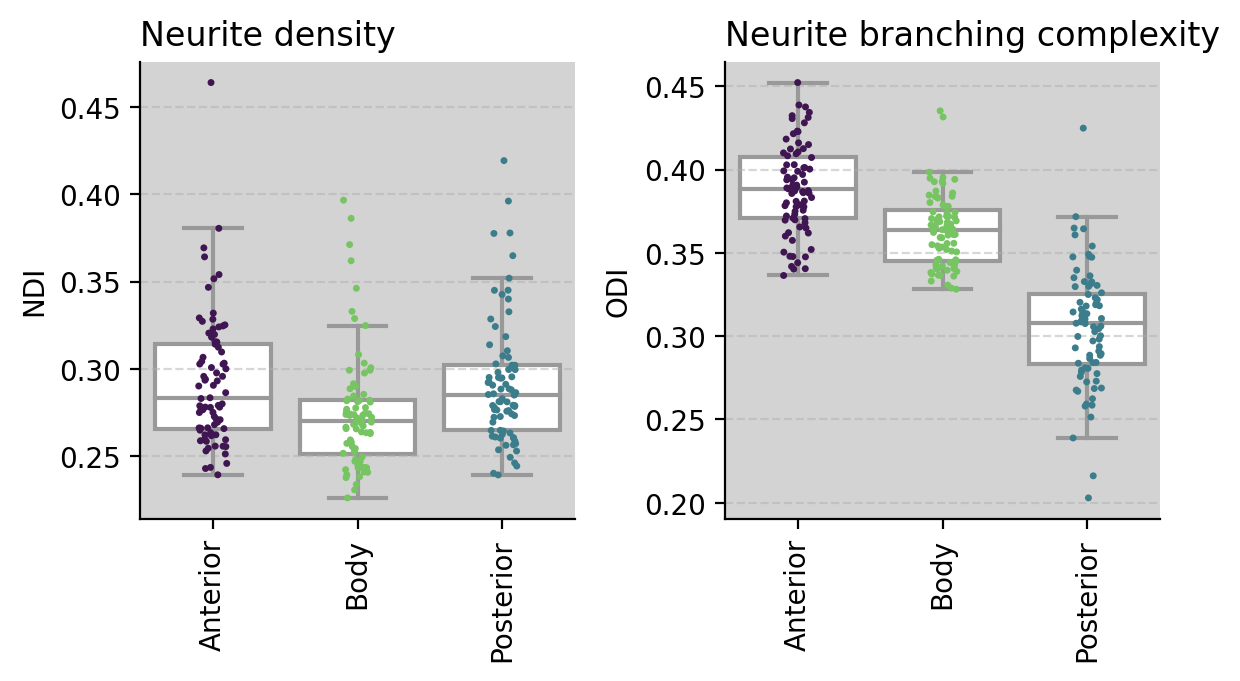

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5))

ylabels = ['NDI','ODI']
titles = ['Neurite density','Neurite branching complexity']

for idx, feature in enumerate(['NDI','ODI']):

    pos_colors[f'{feature}_anterior'] = pos_colors['anterior']
    pos_colors[f'{feature}_body'] = pos_colors['body']
    pos_colors[f'{feature}_posterior'] = pos_colors['posterior']

    df_feature = df[df.Age >= 18].melt(value_vars=[f'{feature}_body',f'{feature}_anterior',f'{feature}_posterior']).sort_values('variable')

    sns.stripplot(data=df_feature, x='variable', y='value', color='k', marker='.', palette=pos_colors, ax=ax[idx])
    sns.boxplot(data=df_feature, x='variable', y='value',color='white', showfliers=False, ax=ax[idx])

    sns.despine()
    
    if idx > 1:
        ax[idx].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax[idx].set_xlabel('')
    ax[idx].set_title(titles[idx], loc='left')
    ax[idx].set_ylabel(ylabels[idx])
    ax[idx].set_facecolor('lightgray')
    ax[idx].grid(axis='y', linestyle='--', alpha=.5)
    ax[idx].set_xticklabels(['Anterior','Body','Posterior'], rotation=90)
    ax[idx].ticklabel_format(style='scientific', axis='y')

plt.tight_layout()
plt.show()

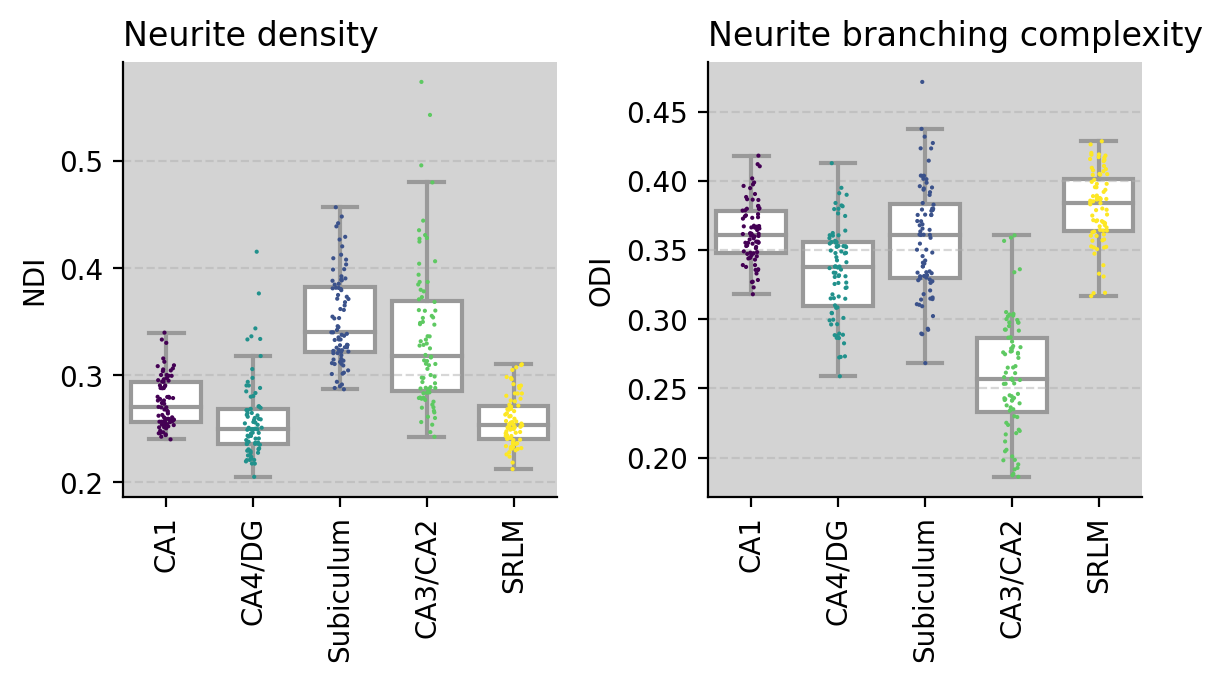

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5))

titles = ['Neurite density','Neurite branching complexity']
ylabels = ['NDI','ODI']

for idx, feature in enumerate(['NDI','ODI']):

    df_feature = df[df.Age >= 18].melt(value_vars=[
        f'{feature}-CA1',
        f'{feature}-CA4/DG',
        f'{feature}-Subiculum',
        f'{feature}-CA3/CA2',
        f'{feature}-SRLM'
        ])
    df_feature.variable = [df_feature.variable[n].split('-')[1] for n in range(df_feature.shape[0])]

    sns.stripplot(data=df_feature, x='variable', y='value', color='k', marker='.', palette=subfield_colors, ax=ax[idx], size=3)
    sns.boxplot(data=df_feature, x='variable', y='value', color='white', showfliers=False, ax=ax[idx])

    sns.despine()
    
    if idx > 1:
        ax[idx].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax[idx].set_xlabel('')
    ax[idx].set_title(titles[idx], loc='left')
    ax[idx].set_ylabel(ylabels[idx])
    ax[idx].grid(axis='y', linestyle='--', alpha=.5)
    ax[idx].set_facecolor('lightgray')
    ax[idx].set_xticklabels(labels=ax[idx].get_xticklabels(), rotation=90)
    ax[idx].ticklabel_format(style='scientific', axis='y')

plt.tight_layout()
plt.show()


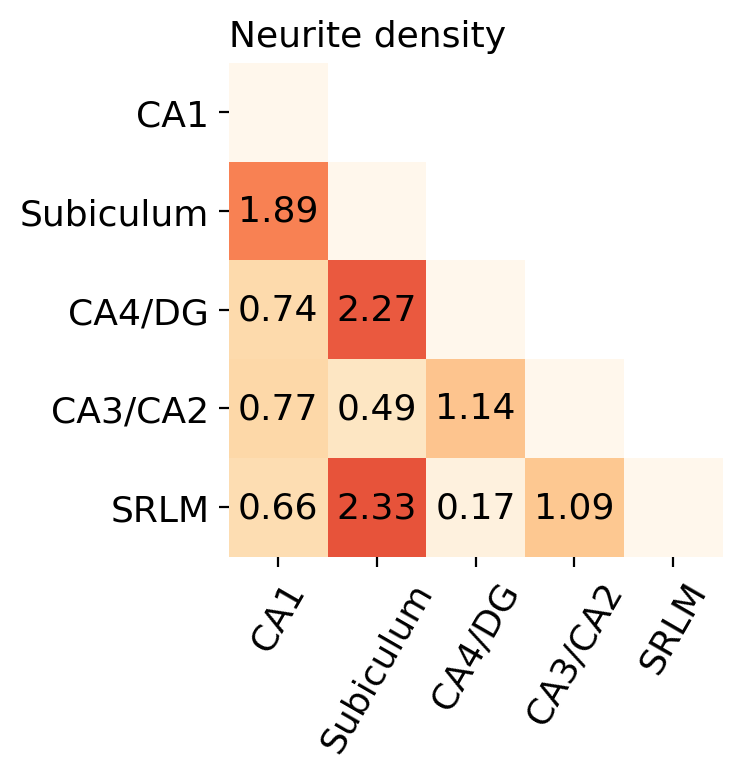

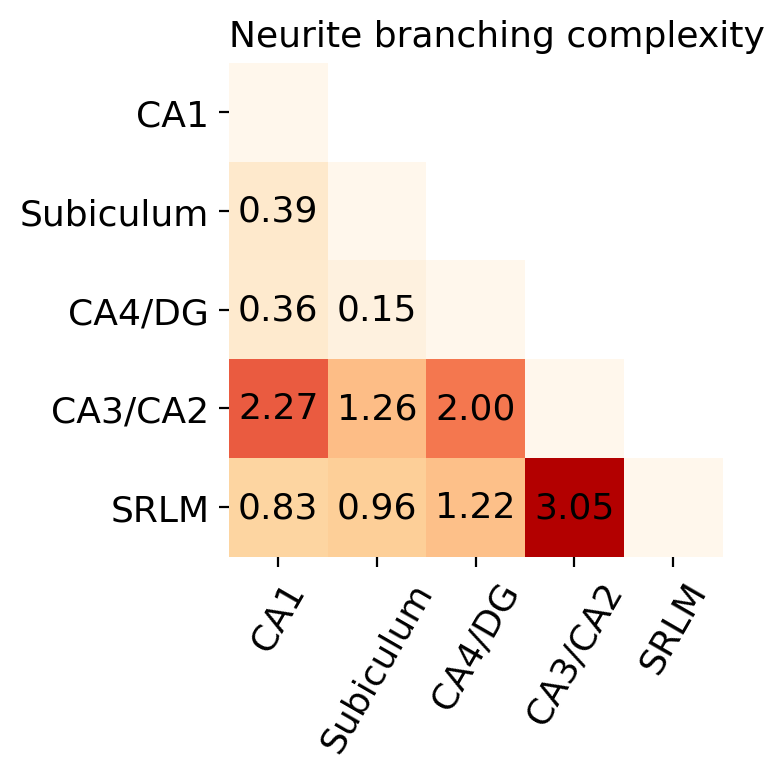

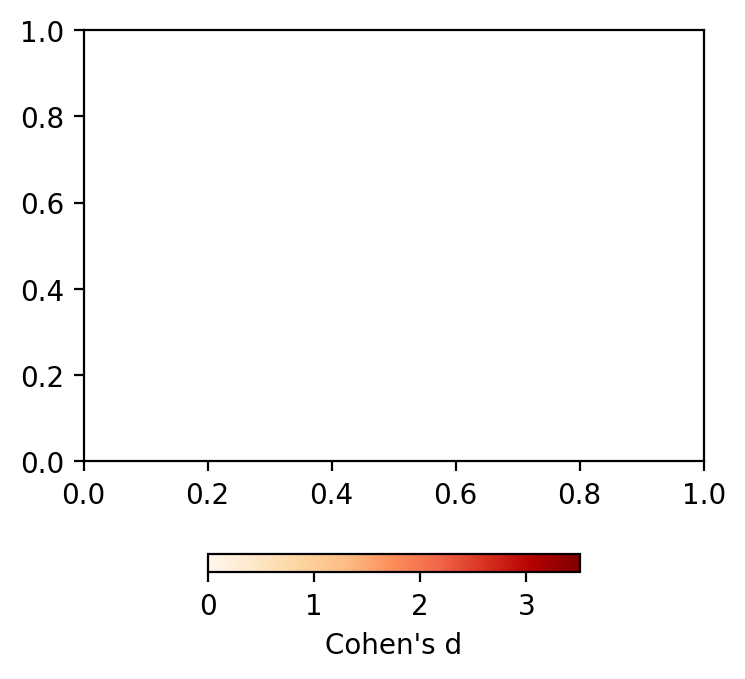

CA1     Subiculum         CA4/DG        CA3/CA2  SRLM
CA1         1.000000e+00           NaN            NaN            NaN   NaN
Subiculum   2.343124e-07  1.000000e+00            NaN            NaN   NaN
CA4/DG      1.854051e-06  4.213038e-02   1.000000e+00            NaN   NaN
CA3/CA2    1.395598e-132  5.456280e-55  3.227400e-111   1.000000e+00   NaN
SRLM        3.204745e-27  1.648158e-34   5.369244e-52  5.571971e-192   1.0

In [38]:
subfields = list(subfield_colors.keys())
titles = ['Neurite density','Neurite branching complexity','Mean diffusivity','Radial diffusivity','Axial diffusivity']

for idx, feature in enumerate(['NDI','ODI']):

    diffs = pd.DataFrame(np.zeros([5,5]), columns=subfields, index=subfields)
    p_vals = pd.DataFrame(np.zeros([5,5]), columns=subfields, index=subfields)

    for j in range(len(subfields)):
        for i in range(len(subfields)):
            diffs.loc[subfields[j], subfields[i]] = pg.ttest(df[f'{feature}-{subfields[i]}'], df[f'{feature}-{subfields[j]}'])['cohen-d'][0]
            p_vals.loc[subfields[j], subfields[i]] = pg.ttest(df[f'{feature}-{subfields[i]}'], df[f'{feature}-{subfields[j]}'])['p-val'][0]

    diffs.values[np.triu_indices_from(diffs, k=1)] = np.nan
    p_vals.values[np.triu_indices_from(p_vals, k=1)] = np.nan

    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(diffs, cmap='OrRd', vmin=0, vmax=3.5)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(subfields, fontsize=13)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(subfields, rotation=60, fontsize=13)
    ax.set_title(titles[idx], loc='left', fontsize=13)

    for j in range(len(subfields)):
        for i in range(len(subfields)):
            if p_vals.loc[subfields[j], subfields[i]] < .05:
                plt.text(i,j, f'{diffs.loc[subfields[j], subfields[i]]:.2f}', ha='center', va='center', fontsize=13)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
cbar = fig.colorbar(cax, ax=ax, label="Cohen's d", shrink=.6, orientation='horizontal')
plt.show()
p_vals

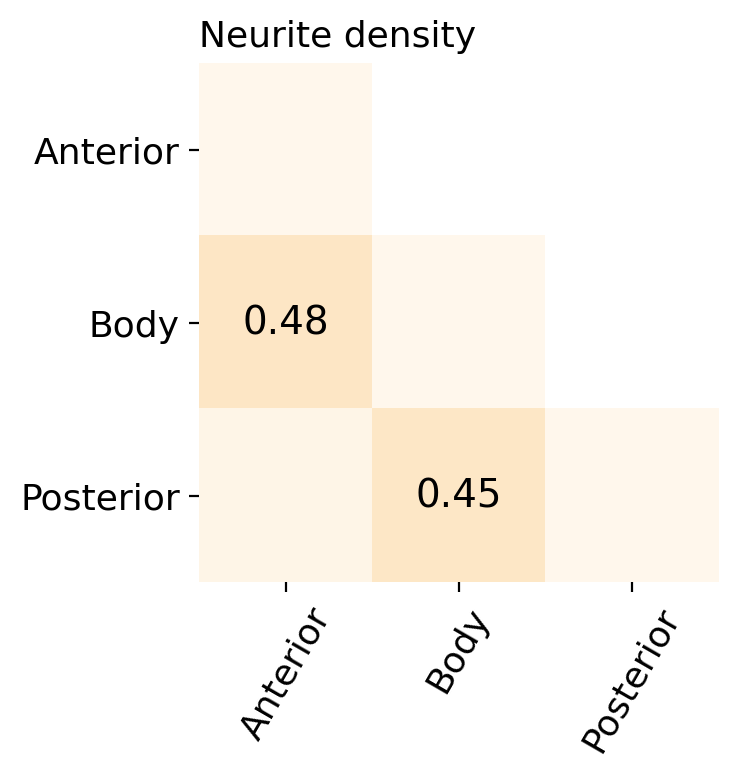

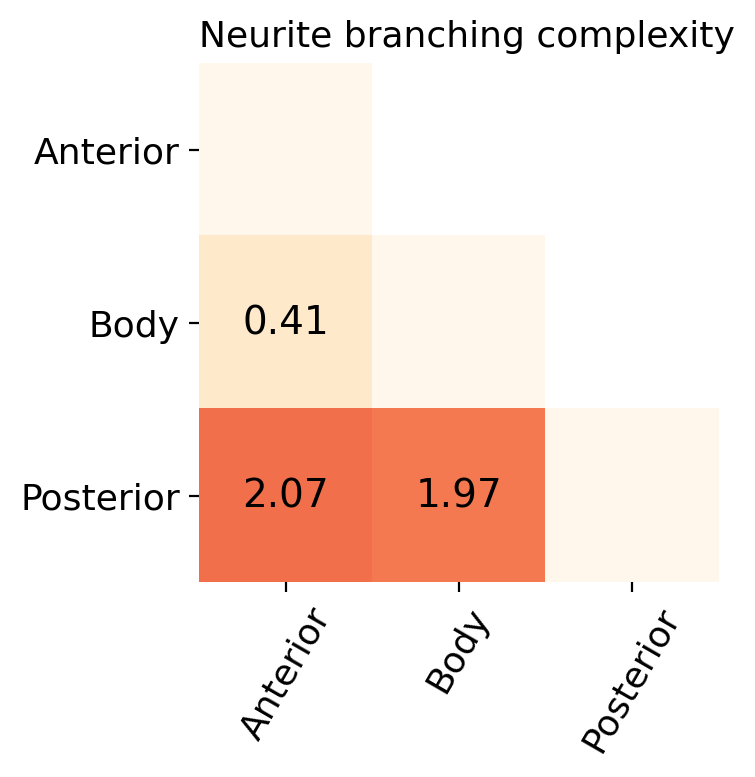

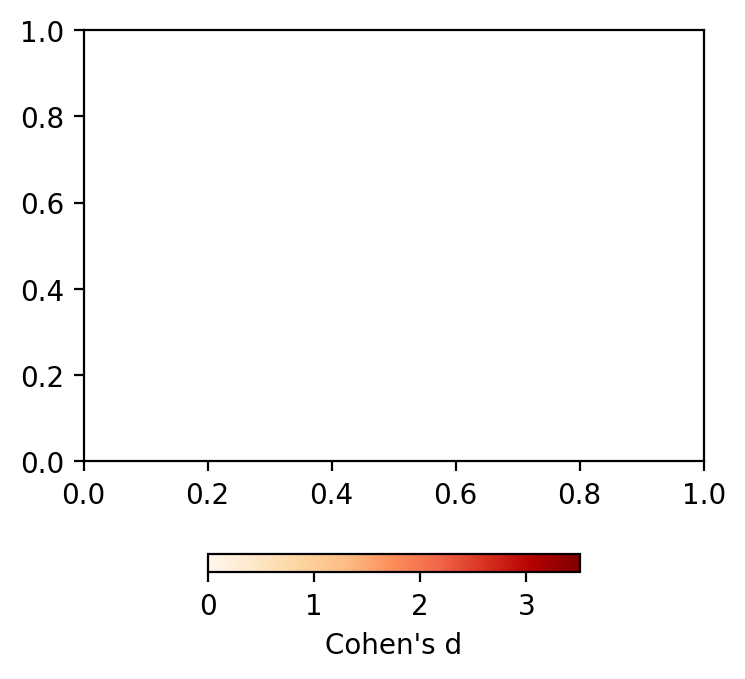

In [ ]:
pos_colors = {
    'anterior':(63/255, 21/255, 82/255),
    'body':(119/255, 196/255, 98/255),
    'posterior':(60/255, 125/255, 140/255)
}
pos = list(pos_colors.keys())
titles = ['Neurite density','Neurite branching complexity','Mean diffusivity','Radial diffusivity','Axial diffusivity']

for idx, feature in enumerate(['NDI','ODI']):

    diffs = pd.DataFrame(np.zeros([3,3]), columns=pos, index=pos)
    p_vals = pd.DataFrame(np.zeros([3,3]), columns=pos, index=pos)

    for j in range(len(pos)):
        for i in range(len(pos)):
            diffs.loc[pos[j], pos[i]] = pg.ttest(df[f'{feature}_{pos[i]}'], df[f'{feature}_{pos[j]}'])['cohen-d'][0]
            p_vals.loc[pos[j], pos[i]] = pg.ttest(df[f'{feature}_{pos[i]}'], df[f'{feature}_{pos[j]}'])['p-val'][0]

    diffs.values[np.triu_indices_from(diffs, k=1)] = np.nan
    p_vals.values[np.triu_indices_from(p_vals, k=1)] = np.nan

    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(diffs, cmap='OrRd', vmin=0, vmax=3.5)
    ax.set_yticks([0,1,2])
    ax.set_yticklabels([x.capitalize() for x in pos], fontsize=13)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels([x.capitalize() for x in pos], rotation=60, fontsize=13)
    ax.set_title(titles[idx], loc='left', fontsize=13)

    for j in range(len(pos)):
        for i in range(len(pos)):
            if p_vals.loc[pos[j], pos[i]] < .05:
                plt.text(i,j, f'{diffs.loc[pos[j], pos[i]]:.2f}', ha='center', va='center', fontsize=14)

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
cbar = fig.colorbar(cax, ax=ax, label="Cohen's d", shrink=.6, orientation='horizontal')
plt.show()



In [ ]:
subject_data = pd.read_csv(f'{project_dir}/data/raw/microstructure_ant_body_post.csv')
site_info = pd.read_excel(f'{project_dir}/src/data/hippocampus_gxp_clean.xlsx', sheet_name='site_info')
noddi_site_vals = pd.read_csv(f'{project_dir}/data/raw/NODDI_site_vals.csv')


NDI       ODI   NDI_age   ODI_age
0    0.366697  0.345713  0.246787  0.095977
1    0.374429  0.348985  0.213900  0.104002
2    0.401824  0.342991  0.287547  0.257550
3    0.658187  0.411259  0.166448 -0.040381
4    0.351224  0.265546  0.241203  0.194857
..        ...       ...       ...       ...
102  0.236817  0.327761  0.111499  0.183564
103  0.313235  0.240063  0.204846  0.281408
104  0.243459  0.276485  0.120602  0.123552
105  0.250295  0.306564  0.130492  0.156787
106  0.252666  0.338142  0.103385  0.183261

[107 rows x 4 columns]

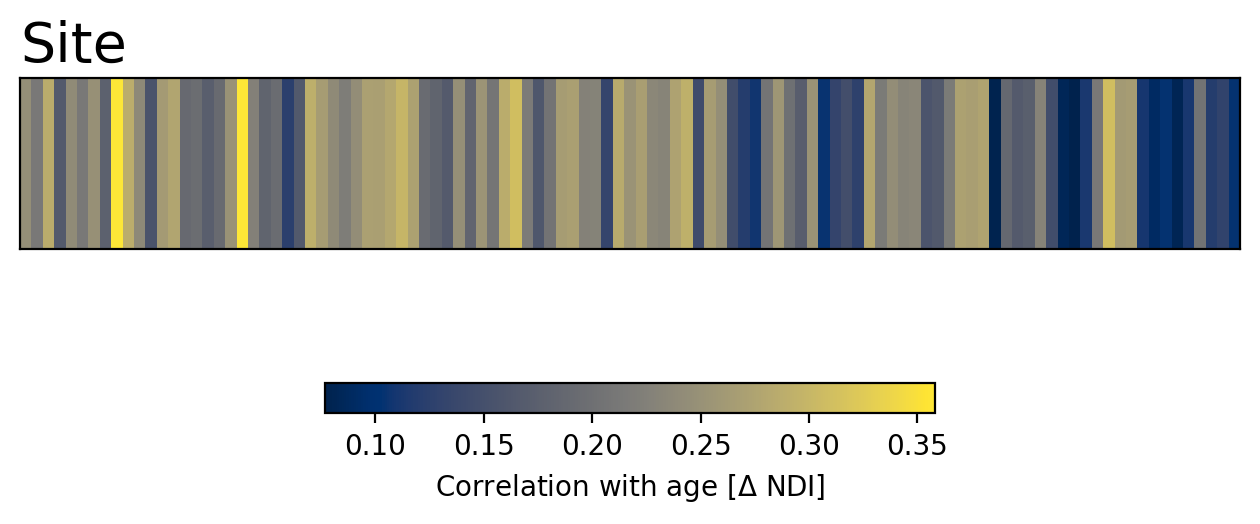

In [ ]:
# RdBu_r
plt.imshow(
    np.reshape(noddi_site_vals['NDI_age'], (-1, 1)).T,
    aspect=15, cmap='cividis'
)

# sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.title('Site', loc='left', fontsize=20)
# plt.xlabel("Correlation with age [$\Delta$ NDI]", fontsize=20)
plt.colorbar(label="Correlation with age [$\Delta$ NDI]", shrink=.5, orientation='horizontal')
plt.tight_layout()

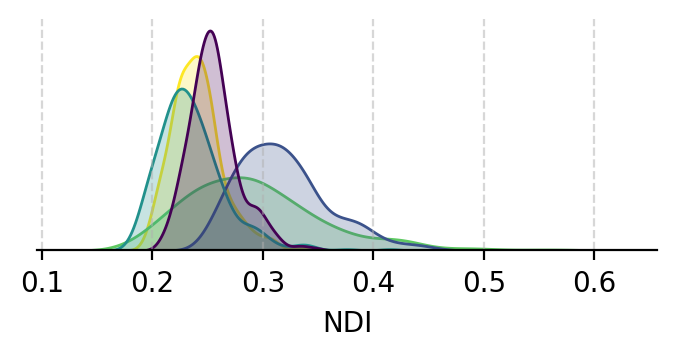

NDI: 43.5 [35.5, 51.5]


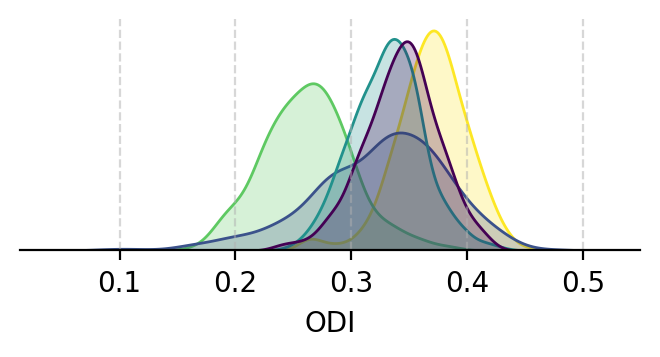

ODI: 44.7 [34.1, 55.2]


In [74]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


accs = {}
for idx, feature in enumerate(['NDI','ODI']):

    fig, ax = plt.subplots(figsize=(4, 1.5))
    df_feature = df.melt(value_vars=[
        f'{feature}-CA1',
        f'{feature}-CA4/DG',
        f'{feature}-Subiculum',
        f'{feature}-CA3/CA2',
        f'{feature}-SRLM'
        ])
    df_feature['variable'] = [x.strip(f'{feature}-') for x in df_feature['variable']]

    sns.kdeplot(data=df_feature, x='value', hue='variable', fill=True, palette=subfield_colors, ax=ax, legend=False)
    ax.set_xlabel(feature)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_yticklabels('')
    ax.grid(axis='x', linestyle='--', alpha=.5)
    sns.despine(left=True)
    plt.show()

    clf = SVC()
    clf.fit(df_feature['value'].to_numpy().reshape(-1, 1), df_feature['variable'])
    y_pred = clf.predict(df_feature['value'].to_numpy().reshape(-1, 1))
    accuracy_mean = accuracy_score(df_feature['variable'], y_pred)

    accuracy_bs = []
    for n in range(50):
        df_feature = df_feature.sample(len(df_feature), replace=True)
        clf.fit(df_feature['value'].to_numpy().reshape(-1, 1), df_feature['variable'])
        y_pred = clf.predict(df_feature['value'].to_numpy().reshape(-1, 1))
        accuracy_bs.append(accuracy_score(df_feature['variable'], y_pred))

    ci_min = accuracy_mean - (np.std(accuracy_bs)*1.96)
    ci_max = accuracy_mean + (np.std(accuracy_bs)*1.96)
    print(f'{feature}: {accuracy_mean*100:2.1f} [{ci_min*100:2.1f}, {ci_max*100:2.1f}]')
    accs[f'{feature}_mean'] = accuracy_mean
    accs[f'{feature}_error'] = (np.std(accuracy_bs)*1.96)



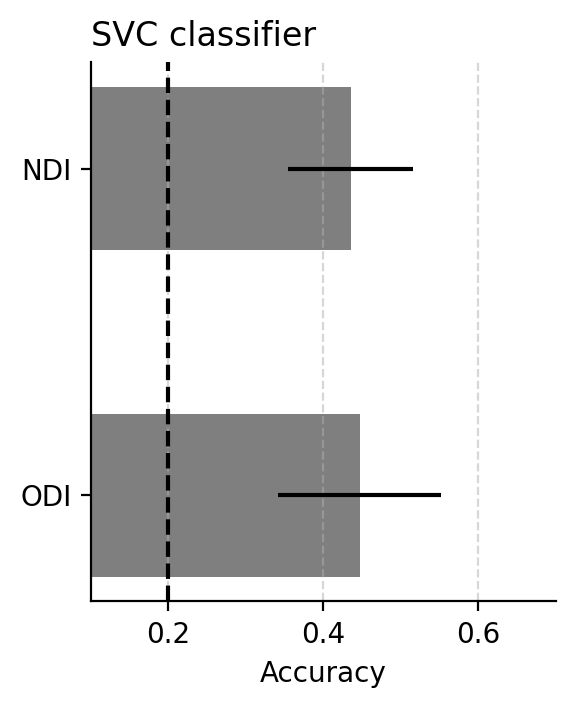

In [75]:
fig, ax = plt.subplots(figsize=(3, 3.5))
ax.barh(y=['ODI','NDI'], width=[accs['ODI_mean'],accs['NDI_mean']], facecolor='tab:gray', height=.5)
ax.errorbar(
    y=['ODI','NDI'], x=[accs['ODI_mean'],accs['NDI_mean']], 
    xerr=[accs['ODI_error'],accs['NDI_error']],
    color='k', fmt='none'
)
ax.axvline(.2, color='k', linestyle='--')
ax.grid(axis='x', linestyle='--', alpha=.5)
ax.set_xlabel('Accuracy')
ax.set_title('SVC classifier', loc='left')
ax.set_xlim([0.1,.7])
sns.despine()



NDI: 43.9 [32.8, 54.9]
ODI: 64.8 [59.6, 70.1]


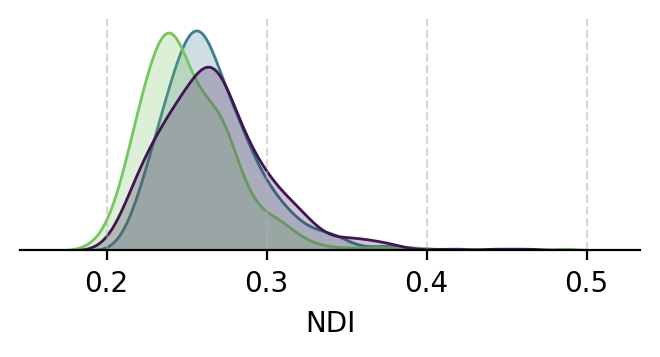

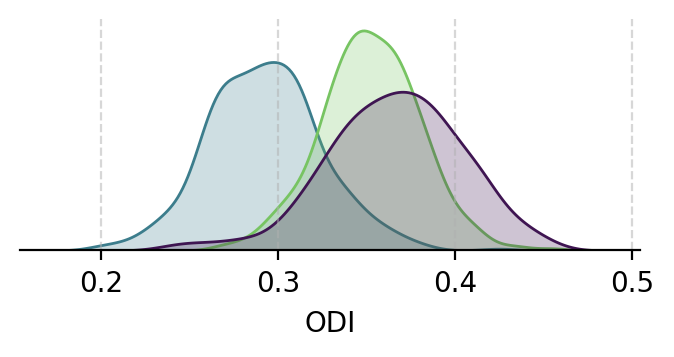

In [72]:

accs = {}

for idx, feature in enumerate(['NDI','ODI']):

    fig, ax = plt.subplots(figsize=(4, 1.5))
    df_feature = df.melt(value_vars=[
        f'{feature}_anterior',
        f'{feature}_body',
        f'{feature}_posterior',
        ])
    df_feature['variable'] = [x.strip(f'{feature}_') for x in df_feature['variable']]

    sns.kdeplot(data=df_feature, x='value', hue='variable', fill=True, palette=pos_colors, ax=ax, legend=False)
    ax.set_xlabel(feature)
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_yticklabels('')
    ax.grid(axis='x', linestyle='--', alpha=.5)
    sns.despine(left=True)

    clf = SVC()
    clf.fit(df_feature['value'].to_numpy().reshape(-1, 1), df_feature['variable'])
    y_pred = clf.predict(df_feature['value'].to_numpy().reshape(-1, 1))
    accuracy_mean = accuracy_score(df_feature['variable'], y_pred)

    accuracy_bs = []
    for n in range(50):
        df_feature = df_feature.sample(len(df_feature), replace=True)
        clf.fit(df_feature['value'].to_numpy().reshape(-1, 1), df_feature['variable'])
        y_pred = clf.predict(df_feature['value'].to_numpy().reshape(-1, 1))
        accuracy_bs.append(accuracy_score(df_feature['variable'], y_pred))

    ci_min = accuracy_mean - (np.std(accuracy_bs)*1.96)
    ci_max = accuracy_mean + (np.std(accuracy_bs)*1.96)

    print(f'{feature}: {accuracy_mean*100:2.1f} [{ci_min*100:2.1f}, {ci_max*100:2.1f}]')
    accs[f'{feature}_mean'] = accuracy_mean
    accs[f'{feature}_error'] = (np.std(accuracy_bs)*1.96)


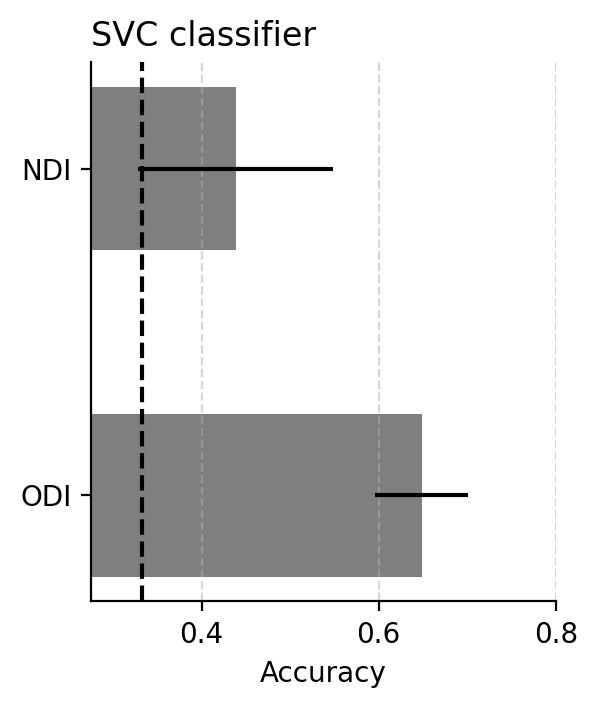

In [73]:

fig, ax = plt.subplots(figsize=(3, 3.5))
ax.barh(y=['ODI','NDI'], width=[accs['ODI_mean'],accs['NDI_mean']], facecolor='tab:gray', height=.5)
ax.errorbar(
    y=['ODI','NDI'], x=[accs['ODI_mean'],accs['NDI_mean']], 
    xerr=[accs['ODI_error'],accs['NDI_error']],
    color='k', fmt='none'
)
ax.axvline(1/3, color='k', linestyle='--')
ax.grid(axis='x', linestyle='--', alpha=.5)
ax.set_xlabel('Accuracy')
ax.set_title('SVC classifier', loc='left')
ax.set_xlim([0.275,.8])
sns.despine()


14.999999999999979
13.899999999999983
13.899999999999983


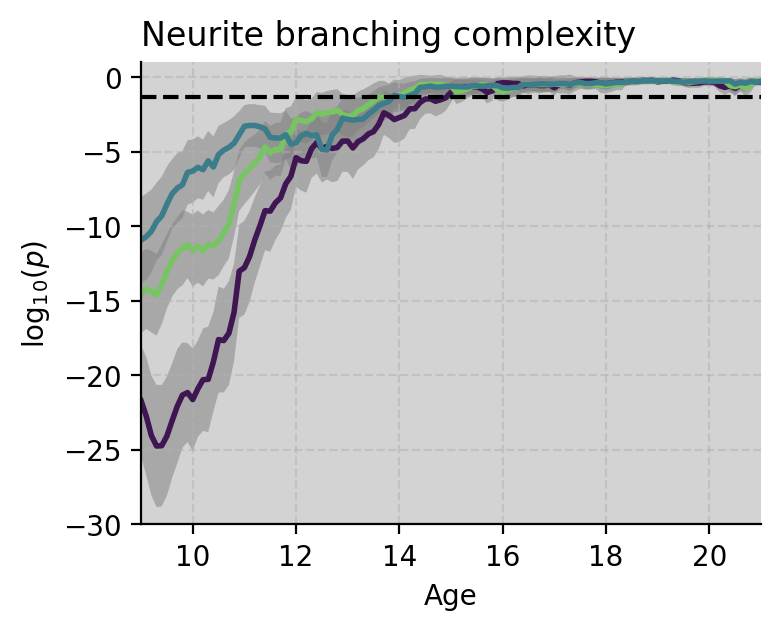

15.099999999999978
15.999999999999975
17.29999999999997


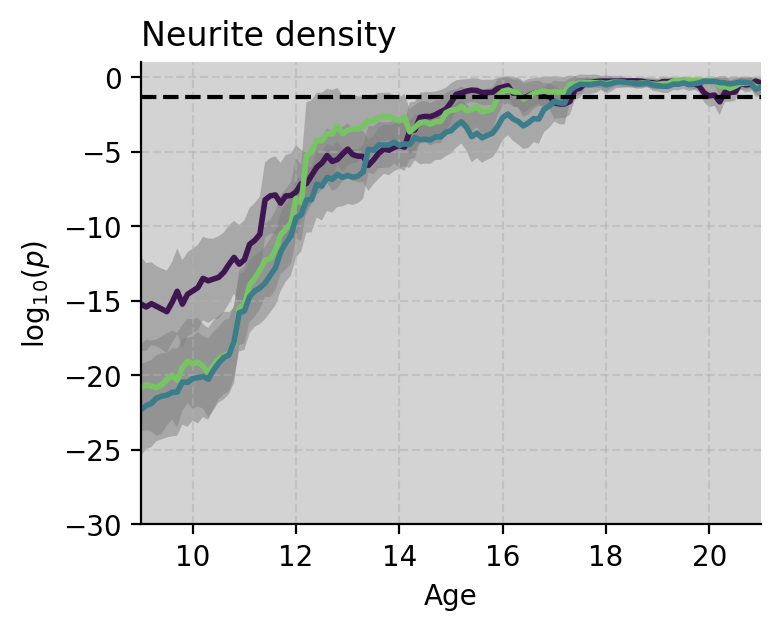

In [112]:
fig, ax = plt.subplots(figsize=(4, 3))

for pos in ['anterior','body','posterior']:
    for idx, feature in enumerate(['ODI']):

        vals_sample = []
        for sample in range(50):
            df_s = df.sample(len(df), replace=True)

            vals = []
            for median_age in np.arange(9,22,.1):
                vals.append(np.log10(pg.ttest(
                    np.concatenate(df_s[(df_s.Age > (median_age - 1)) & (df_s.Age < (median_age + 1))][[f'{feature}_{pos}']].values),
                    np.concatenate(df_s[df_s.Age >= 18][[f'{feature}_{pos}']].values)
                )['p-val'][0]))

            vals_sample.append(vals)

        mean_vals = np.mean(vals_sample, axis=0)
        err_vals = np.std(vals_sample, axis=0)
        plt.plot(np.arange(9,22,.1), mean_vals, color=pos_colors[pos], lw=2)
        plt.fill_between(np.arange(9,22,.1), mean_vals-err_vals, mean_vals+err_vals, facecolor='tab:gray', alpha=.5)

        print(np.arange(9,22,.1)[np.array(mean_vals) > -1.3][0])


sns.despine()
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('Age')
ax.set_facecolor('lightgray')
ax.set_ylabel('log$_1$$_0$($p$)')
ax.set_xlim([9, 21])
ax.set_title('Neurite branching complexity', loc='left')
ax.set_ylim([-30,1])
ax.axhline(np.log10(.05), linestyle='--', color='k')

plt.show()



fig, ax = plt.subplots(figsize=(4, 3))

for pos in ['anterior','body','posterior']:
    for idx, feature in enumerate(['NDI']):

        vals_sample = []
        for sample in range(50):
            df_s = df.sample(len(df), replace=True)

            vals = []
            for median_age in np.arange(9,22,.1):
                vals.append(np.log10(pg.ttest(
                    np.concatenate(df_s[(df_s.Age > (median_age - 1)) & (df_s.Age < (median_age + 1))][[f'{feature}_{pos}']].values),
                    np.concatenate(df_s[df_s.Age >= 18][[f'{feature}_{pos}']].values)
                )['p-val'][0]))

            vals_sample.append(vals)

        mean_vals = np.mean(vals_sample, axis=0)
        err_vals = np.std(vals_sample, axis=0)
        plt.plot(np.arange(9,22,.1), mean_vals, color=pos_colors[pos], lw=2)
        plt.fill_between(np.arange(9,22,.1), mean_vals-err_vals, mean_vals+err_vals, facecolor='tab:gray', alpha=.5)

        print(np.arange(9,22,.1)[np.array(mean_vals) > -1.3][0])


sns.despine()
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('Age')
ax.set_facecolor('lightgray')
ax.set_ylabel('log$_1$$_0$($p$)')
ax.set_xlim([9, 21])
ax.set_title('Neurite density', loc='left')
ax.set_ylim([-30,1])
ax.axhline(np.log10(.05), linestyle='--', color='k')

plt.show()

14.39999999999998
14.59999999999998
10.899999999999993
9.0
13.699999999999983


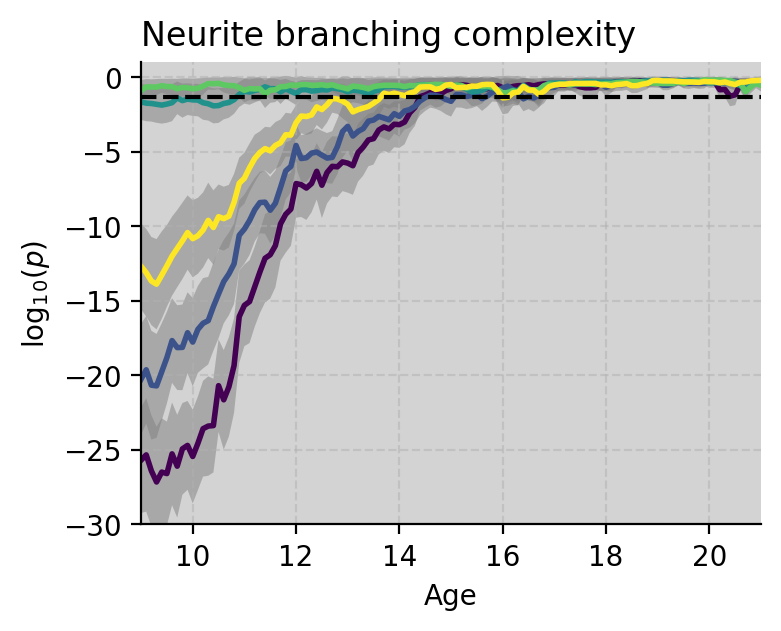

17.39999999999997
17.29999999999997
17.29999999999997
15.999999999999975
15.499999999999977


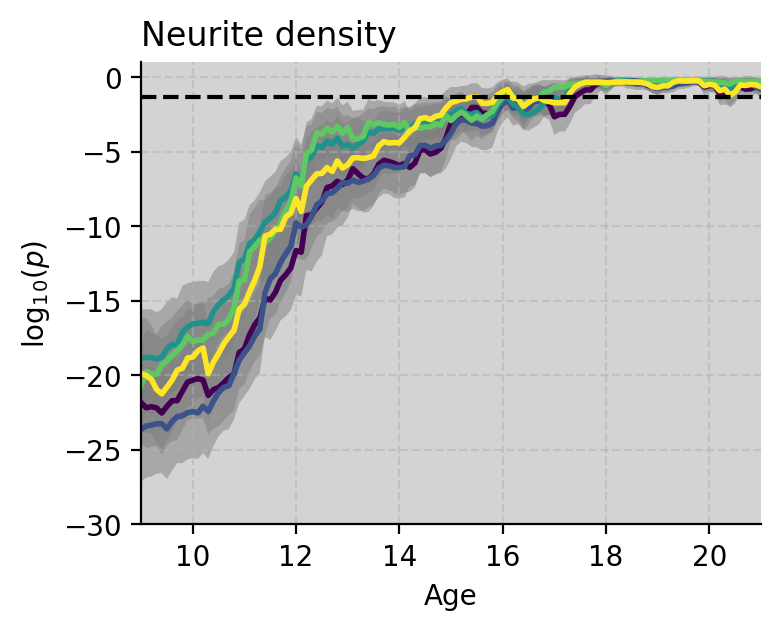

In [114]:
fig, ax = plt.subplots(figsize=(4, 3))

for subfield in subfield_colors.keys():
    for idx, feature in enumerate(['ODI']):

        vals_sample = []
        for sample in range(50):
            df_s = df.sample(len(df), replace=True)

            vals = []
            for median_age in np.arange(9,22,.1):
                vals.append(np.log10(pg.ttest(
                    np.concatenate(df_s[(df_s.Age > (median_age - 1)) & (df_s.Age < (median_age + 1))][[f'{feature}-{subfield}']].values),
                    np.concatenate(df_s[df_s.Age >= 18][[f'{feature}-{subfield}']].values)
                )['p-val'][0]))

            vals_sample.append(vals)

        mean_vals = np.mean(vals_sample, axis=0)
        err_vals = np.std(vals_sample, axis=0)
        plt.plot(np.arange(9,22,.1), mean_vals, color=subfield_colors[subfield], lw=2)
        plt.fill_between(np.arange(9,22,.1), mean_vals-err_vals, mean_vals+err_vals, facecolor='tab:gray', alpha=.5)

        print(np.arange(9,22,.1)[np.array(mean_vals) > -1.3][0])


sns.despine()
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('Age')
ax.set_facecolor('lightgray')
ax.set_ylabel('log$_1$$_0$($p$)')
ax.set_xlim([9, 21])
ax.set_title('Neurite branching complexity', loc='left')
ax.set_ylim([-30,1])
ax.axhline(np.log10(.05), linestyle='--', color='k')

plt.show()


fig, ax = plt.subplots(figsize=(4, 3))

for subfield in subfield_colors.keys():
    for idx, feature in enumerate(['NDI']):

        vals_sample = []
        for sample in range(50):
            df_s = df.sample(len(df), replace=True)

            vals = []
            for median_age in np.arange(9,22,.1):
                vals.append(np.log10(pg.ttest(
                    np.concatenate(df_s[(df_s.Age > (median_age - 1)) & (df_s.Age < (median_age + 1))][[f'{feature}-{subfield}']].values),
                    np.concatenate(df_s[df_s.Age >= 18][[f'{feature}-{subfield}']].values)
                )['p-val'][0]))

            vals_sample.append(vals)

        mean_vals = np.mean(vals_sample, axis=0)
        err_vals = np.std(vals_sample, axis=0)
        plt.plot(np.arange(9,22,.1), mean_vals, color=subfield_colors[subfield], lw=2)
        plt.fill_between(np.arange(9,22,.1), mean_vals-err_vals, mean_vals+err_vals, facecolor='tab:gray', alpha=.5)

        print(np.arange(9,22,.1)[np.array(mean_vals) > -1.3][0])


sns.despine()
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('Age')
ax.set_facecolor('lightgray')
ax.set_ylabel('log$_1$$_0$($p$)')
ax.set_xlim([9, 21])
ax.set_title('Neurite density', loc='left')
ax.set_ylim([-30,1])
ax.axhline(np.log10(.05), linestyle='--', color='k')

plt.show()


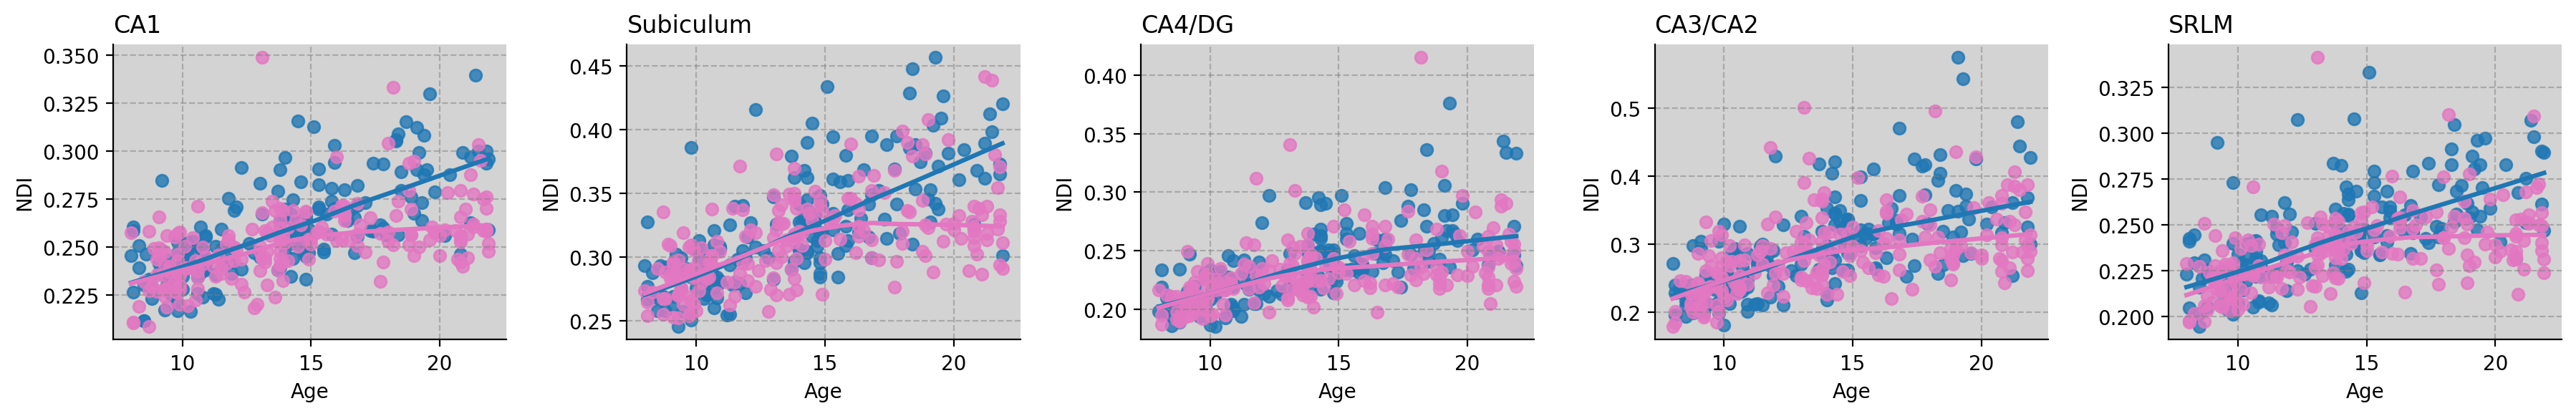

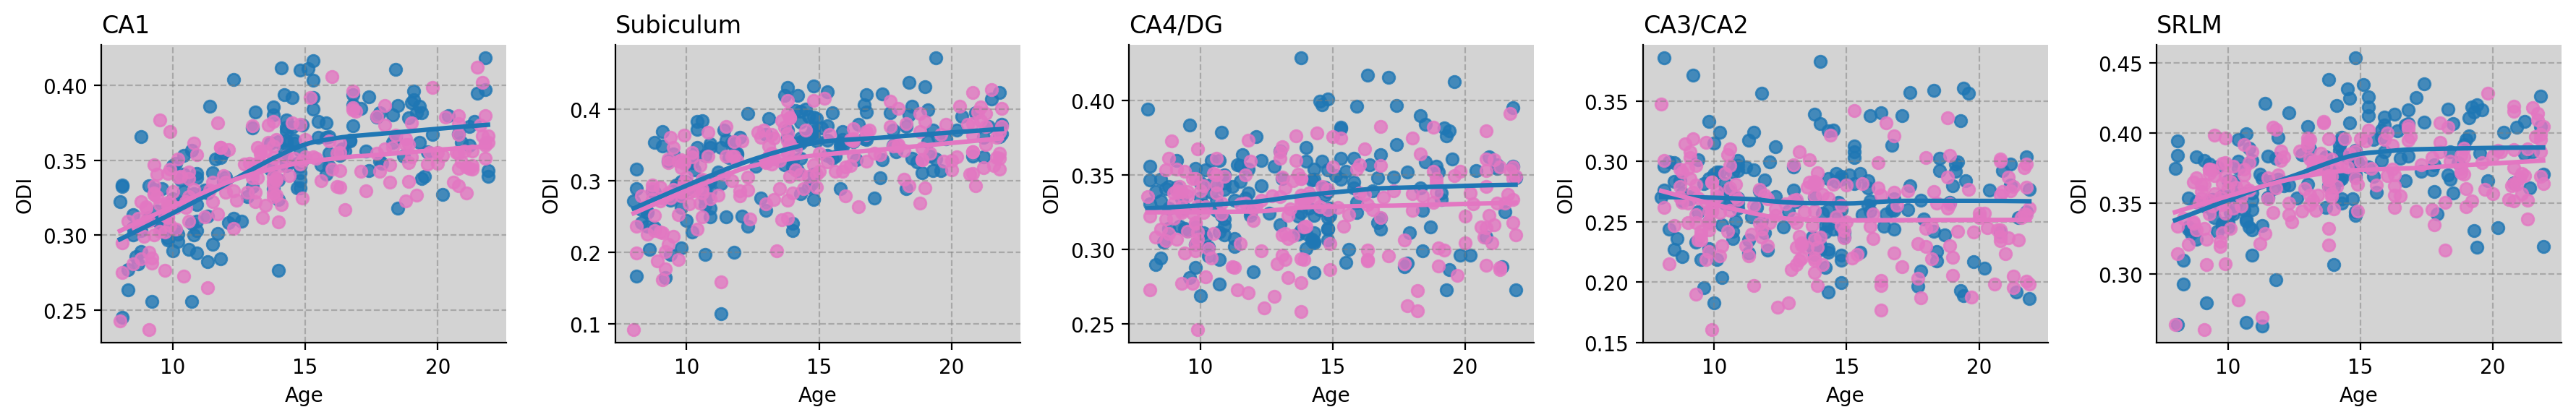

In [ ]:

for metric in ['NDI','ODI']:
    fig, ax = plt.subplots(1, 5, figsize=(18, 3))

    for idx, subfield in enumerate(subfield_colors.keys()):

        sns.regplot(data=df[df.Sex == 0], x='Age', y=f'{metric}-{subfield}', color='tab:blue', lowess=True, ax=ax[idx])
        sns.regplot(data=df[df.Sex == 1], x='Age', y=f'{metric}-{subfield}', color='tab:pink', lowess=True, ax=ax[idx])
        sns.despine()
        ax[idx].grid(linestyle='--', alpha=.5, color='tab:gray')
        ax[idx].set_title(subfield, loc='left')
        ax[idx].set_ylabel(metric)
        ax[idx].set_facecolor('lightgray')

    plt.tight_layout()
    plt.show()

